**Import all the required library**

In [1]:
import torch,gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

**Empty GPU's memory/cache for training so we'd clear garbage values in it and more memory will be available**

In [2]:
torch.cuda.empty_cache()

## Custom Dataset Class

**Create a custom dataset class that augments each image into 4 different angles: 0, 45, 90, 120, 180, 270, 300, 330 degrees. Fuse it with Pytorch's DataLoader class so data can be loaded, augmented and trained in realtime instead of caching all training samples in memory for augmenting.**

In [3]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    
    # Transformation for converting original image array to an image and then convert it to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -45 degrees and 45 degrees, and then convert it to a tensor
    self.transform1 = transforms.Compose([
        transforms.ToPILImage(),                                          
        transforms.RandomRotation(45),
        transforms.ToTensor()                                 
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -90 degrees and 90 degrees, and then convert it to a tensor
    self.transform2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -120 degrees and 120 degrees, and then convert it to a tensor
    self.transform3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(120),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -180 degrees and 180 degrees, and then convert it to a tensor
    self.transform4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(180),
        transforms.ToTensor()                                
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -270 degrees and 270 degrees, and then convert it to a tensor
    self.transform5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(270),
        transforms.ToTensor()                                
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -300 degrees and 300 degrees, and then convert it to a tensor
    self.transform6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(300),
        transforms.ToTensor()                               
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -330 degrees and 330 degrees, and then convert it to a tensor
    self.transform7 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(330),
        transforms.ToTensor()                                 
    ])

  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # Original image as a tensor
    data = self.transform(self.X[idx])

    # Augmented image at 45 degrees as a tensor
    aug45 = self.transform1(self.X[idx])

    # Augmented image at 90 degrees as a tensor
    aug90 = self.transform2(self.X[idx])

    # Augmented image at 120 degrees as a tensor
    aug120 = self.transform3(self.X[idx])

    # Augmented image at 180 degrees as a tensor
    aug180 = self.transform4(self.X[idx])

    # Augmented image at 270 degrees as a tensor
    aug270 = self.transform5(self.X[idx])

    # Augmented image at 300 degrees as a tensor
    aug300 = self.transform6(self.X[idx])

    # Augmented image at 330 degrees as a tensor
    aug330 = self.transform7(self.X[idx])      
    
    # store the transformed images in a list
    new_batch = [data, aug45, aug90, aug120, aug180, aug270, aug300, aug330]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0

    new_labels = [labels, labels, labels, labels, labels, labels, labels, labels]

    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

## Load the Dataset

* Load the **training_data.pickle** file. 


In [4]:
training_data = pickle.load(open('../input/brain-tumor-classification-mri-images/brain_tumor_mri/new_dataset/training_data.pickle', 'rb'))

In [5]:
Xt = []
yt = []
features = None
labels = None
label = []

**Store images in Xt and labels in yt iteratively**

In [6]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

In [7]:
len(yt)

3064

## Train Validation Test split

Split the dataset for training using cross-validation method.

* 70 % of images for training 
* 15% of images for validating
* 15% of images for testing


In [8]:
# 70 % training, 15% validating, 15% testing
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True)  # 70% training, 30% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  # split testing set into 50% validation , 50% testing 

In [9]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None 

**Create training set, validation set and test set using our custom dataset class**

In [10]:
train_set = BrainTumorDataset(X_train, y_train)
valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

Print original number of samples in each set

In [11]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2144
Number of validation samples: 460
Number of testing samples: 460


**Print augmented number of samples in each set**

In [12]:
print(f"Number of augmented training samples: {len(X_train) * 8}")
print(f"Number of augmented validation samples: {len(X_valid)* 8}")
print(f"Number of augmented testing samples: {len(X_test)* 8}")

Number of augmented training samples: 17152
Number of augmented validation samples: 3680
Number of augmented testing samples: 3680


**Create a DataLoader for each set with batch size of 4 and shuffling enabled**

In [13]:
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)
valid_gen = DataLoader(valid_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)
test_gen = DataLoader(test_set, batch_size=10, shuffle=True, pin_memory=True, num_workers=2)

**Get device to set the training to run on GPU or CPU later based on its availibility**

In [14]:
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
device

device(type='cuda', index=0)

## Build the Model



In [15]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, 4),
                                nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
torch.cuda.empty_cache()

## Set Training Configuration

In [17]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=3e-4)

# number of training iterations
epochs = 5

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

## Util function

### Checkpoint Saver


In [18]:
def save_checkpoint(state, is_best, filename='./bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

## Train the model

**I take iteration upto 5 epochs , since it takes 10 min/epochs, you can increase traning epoch for better accuracy**

In [19]:
# set training start time
start_time = time.time()


# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_gen):
        # set label as cuda if device is cuda

        X = X.to(device)
        y= y.to(device)
          
          # forward pass image sample
        y_pred = resnet_model(X.view(-1, 3, 512, 512))
        gc.collect()
        torch.cuda.empty_cache()
          # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(32, 4), dim=1).long())

          # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
          # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()
          # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
          
          # set optimizer gradients to zero
        optimizer.zero_grad()
          # back propagate with loss
        loss.backward()
          # perform optimizer step
        optimizer.step()
      

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*4}\nAccuracy: {trn_corr.item()*100/(4*8*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(valid_gen):
            X, y = X.to(device), y.to(device)

                # forward pass image
            y_val = resnet_model(X.view(-1, 3, 512, 512))

                # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

                # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(32, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(4*8*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': resnet_model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2144
Accuracy: 47.08 %  Loss: 0.9522  Duration: 10.83 minutes
Validation Accuracy 47.72 Validation Loss: 0.8129

Epoch 2 Batch 2144
Accuracy: 57.87 %  Loss: 0.3891  Duration: 10.81 minutes
Validation Accuracy 66.28 Validation Loss: 1.0268

Epoch 3 Batch 2144
Accuracy: 75.00 %  Loss: 0.6235  Duration: 10.82 minutes
Validation Accuracy 77.47 Validation Loss: 0.4028

Epoch 4 Batch 2144
Accuracy: 81.39 %  Loss: 0.1530  Duration: 10.82 minutes
Validation Accuracy 84.54 Validation Loss: 0.2852

Epoch 5 Batch 2144
Accuracy: 83.11 %  Loss: 0.6477  Duration: 10.81 minutes
Validation Accuracy 85.12 Validation Loss: 0.8749


Training Duration 56.97 minutes
GPU memory used : 389638144 kb
GPU memory cached : 16097738752 kb


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [20]:
torch.cuda.empty_cache()

# Save the model

### Save the model after the training is completed

In [21]:
torch.save(resnet_model.state_dict(), './bt_resnet50_model.pt')

## Evaluation

**Print the validation accuracy of the model calculated using validation set during training**

In [22]:
print(f'Validation accuracy: {test_correct[-1].item()*100/(test_b*8*4):.2f}%')

Validation accuracy: 85.12%


**Plot the loss graph**

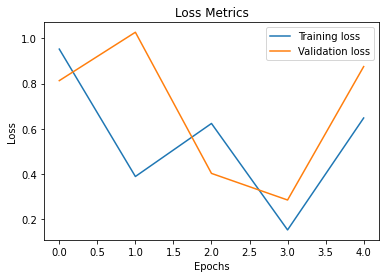

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

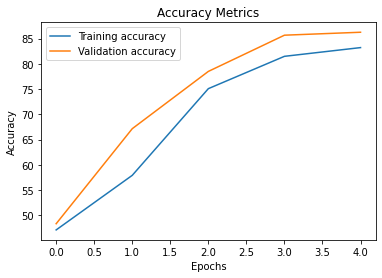

In [24]:
plt.plot([t*(1/171) for t in train_correct], label='Training accuracy')
plt.plot([t*(1/36) for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [25]:
resnet_model.load_state_dict(torch.load('./bt_resnet50_model.pt'))
train_gen = None
valid_gen = None
train_set = None
valid_set = None

**Set model to evaluation mode**

**Calculate loss, correctly classified samples, predicted values, labels and store them in a list using test dataloader**

In [26]:
# set model to evaluation mode
resnet_model.eval()

# perform no gradient updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    correct = 0
    test_loss = []
    test_corr = []
    labels = []
    pred = []
    # perform test set evaluation batch wise
    for (y, X) in test_gen:
        # set label to use CUDA if available
        X, y = X.to(device), y.to(device)

        # append original labels
        labels.append(torch.argmax(y.view(10 * 8, 4), dim=1).data)

        # perform forward pass
        y_val = resnet_model(X.view(-1, 3, 512, 512))

        # get argmax of predicted values, which is our label
        predicted = torch.argmax(y_val, dim=1).data
        # append predicted label
        pred.append(predicted)

        # calculate loss
        loss = criterion(y_val.float(), torch.argmax(y.view(10 * 8, 4), dim=1).long())

        # increment correct with correcly predicted labels per batch
        correct += (predicted == torch.argmax(y.view(10 * 8, 4), dim=1)).sum()

        # append correct samples labels and losses
        test_corr.append(correct)
        test_loss.append(loss)
        
print(f"Test Loss: {test_loss[-1].item():.4f}")

Test Loss: 0.6442


**Print the test accuracy**


In [27]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*8):.2f}%')

Test accuracy: 94.27%


**Get the test accuracy of 92.72% not bad for 5 epochs**

___

**Convert list of tensors to tensors**

In [28]:
labels = torch.stack(labels)
pred = torch.stack(pred)

**Define ground-truth labels as a list**

In [29]:
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

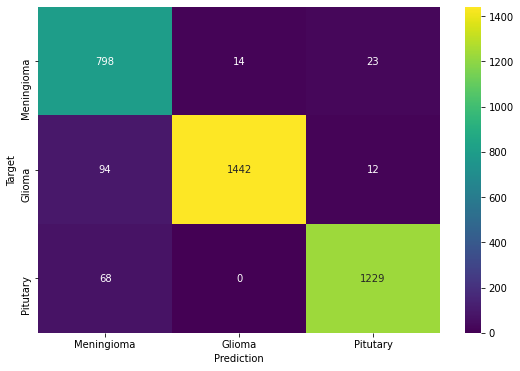

In [30]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()